In [5]:
import warnings
warnings.filterwarnings('ignore')
from tqdm import tqdm
import pandas as pd
import numpy as np
import tensorflow as tf
from sklearn.model_selection import GridSearchCV
from tensorflow.keras.models import Sequential
from keras.regularizers import l1, l2
from tensorflow.keras import initializers
from tensorflow.keras.layers import Dense
from tensorflow.keras.callbacks import EarlyStopping
from scikeras.wrappers import KerasClassifier
from sklearn.model_selection import KFold
import keras_tuner
import keras
from keras import layers
import itertools
from sklearn.model_selection import train_test_split
from keras.optimizers import SGD
from keras.callbacks import EarlyStopping
import matplotlib.pyplot as plt
from sklearn.model_selection import KFold, StratifiedKFold
from sklearn.preprocessing import OneHotEncoder
import keras.backend as K
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from math import ceil


seed = 7
tf.random.set_seed(seed)

In [6]:
def plot_curves(curve_1, label_1, curve_2=None, label_2=None):
    if curve_1 is not None: 
        plt.plot(curve_1, label = label_1)
    if curve_2 is not None: 
        plt.plot(curve_2, label = label_2)   
    plt.legend()
    plt.show()

In [199]:
def load_monks(path, encode):
    
    train = pd.read_csv(f"{path}.train", header=None, sep=" ")
    test = pd.read_csv(f"{path}.test", header=None, sep=" ")
    
    train.drop(0, axis=1, inplace=True)
    test.drop(0, axis=1, inplace=True)
    train.drop(8, axis=1, inplace=True)
    test.drop(8, axis=1, inplace=True)
    
    y_train = train.iloc[:, 0].to_numpy().astype(np.float64)
    x_train = train.iloc[:, 1:].to_numpy().astype(np.float64)
    y_test = test.iloc[:, 0].to_numpy().astype(np.float64)
    x_test = test.iloc[:, 1:].to_numpy().astype(np.float64)
    
        
    if encode:
        
        encoder = OneHotEncoder()
        
        encoder.fit(x_train)
        x_train = encoder.transform(x_train).toarray()
        
        encoder.fit(x_test)
        x_test = encoder.transform(x_test).toarray()
        
        
    
    print(f"Loaded {path} dataset")
    
    return x_train, y_train, x_test, y_test
    

def load_cup(scale):
    train = pd.read_csv("../data/ML-CUP22-TR.csv", header=None, sep=",")
    test = pd.read_csv("../data/ML-CUP22-TS.csv", header=None, sep=",")
    train.drop(0, axis=1, inplace=True)
    test.drop(0, axis=1, inplace=True)

    y_train = train.iloc[:, 9:].to_numpy().astype(np.float64)
    x_train = train.iloc[:, :9].to_numpy().astype(np.float64)
    x_test = test.to_numpy().astype(np.float64)
    
    if scale:
        scaler = StandardScaler()
        # scaler = MinMaxScaler()
        x_train = scaler.fit_transform(x_train)
        x_test = scaler.fit_transform(x_test)
        y_train = scaler.fit_transform(y_train)
        
    return x_train, y_train, x_test, None
    
    
    
def load_dataset(dataset, encode=True):
    assert dataset in ["monks1", "monks2", "monks3", "cup"]
    
    if dataset == "monks1":
        return load_monks("./../data/monks-1", encode)
    elif dataset == "monks2":
        return load_monks("./../data/monks-2", encode)
    elif dataset == "monks3":
        return load_monks("./../data/monks-3", encode)
    else:
        return load_cup(encode)

In [211]:
def median_index(array):
    n = len(array)
    med_idx = np.argsort(array)[ceil((n-1)/2)]
    # med_val = array[med_idx]
    return med_idx #, med_val

def merge_dicts(dicts):
    merged = {}
    for d in dicts:
        merged = {**merged, **d}
    return merged


def get_attributes_num(dataset):
    return 1 if len(dataset.shape) == 1 else dataset.shape[1]


def get_params_configurations(params):
    
    keys = list(params.keys())
    keys.remove("layers")
    keys.remove("task")
    keys.remove("initialization")
    keys.remove("early_stopping")
    keys.remove("regularization")
    keys.remove("trials_train")
    keys.remove("trials_test")
    sorted_keys = sorted(keys)
    arguments = []
    for key in sorted_keys:
        arguments.append(params[key])
    
    arguments = tuple(arguments)
    all_params = list(itertools.product(*arguments))
        
    configurations = []
    
    for conf in all_params:
        
        dict_conf = {}
        
        for i in range(len(sorted_keys)):
            dict_conf[sorted_keys[i]] = conf[i]
        dict_conf["initialization"] = params["initialization"]
        dict_conf["early_stopping"] = params["early_stopping"]
        dict_conf["task"] = params["task"]
        dict_conf["trials_train"] = params["trials_train"]
        dict_conf["trials_test"] = params["trials_test"]
        
        # add regularization parameters
        for reg in params["regularization"]:
            method = reg["type"]
            
            if method == None:
                reg_dict_conf = dict_conf.copy()
                reg_dict_conf["regularization"] = {
                    "method": None
                }
                configurations.append(reg_dict_conf)
                continue
            
            for val in reg["value"]:
                reg_dict_conf = dict_conf.copy()
                reg_dict_conf["regularization"] = {
                    "method": method,
                    "value": val
                }
        
                configurations.append(reg_dict_conf)
            
        
    return configurations



def get_layers_configurations(params, configurations):
    layers = params["layers"]
    layers_params_confs = []
    
    for n_layer in range(len(layers)):
        layers_params_confs.append([]) 
    
    for i in range(len(layers)):
        layer = layers[i]
        activations = layer["activations"]
        units = layer["units"]
        layer_confs = list(itertools.product(activations, units))
        for conf in layer_confs:
            conf_dict = {
                f"activations_{i+1}": conf[0],
                f"units_{i+1}": conf[1]
            }
            layers_params_confs[i].append(conf_dict)
        
    layers_confs = []
    for i in range(len(layers_params_confs)):
        confs = layers_params_confs[:i+1]
        confs = tuple(confs)
        confs = list(itertools.product(*confs))
        for conf in confs:
            layers_confs.append(merge_dicts(conf))
                
    return layers_confs



def get_configurations(params):
    
    configurations = get_params_configurations(params)
    layers_confs = get_layers_configurations(params, configurations)
    configurations = list(itertools.product(configurations, layers_confs))
    configurations_merged = []
    
    for conf in configurations:
        configurations_merged.append(merge_dicts(conf))
        
    
    return configurations_merged

            

def get_model(config, input_size, output_size):
    
    lr = config["learning_rate"]
    momentum = config["momentum"]
    init_method = config["initialization"]["type"]
    task = config["task"]
    
    reg_method = config["regularization"]["method"]
    
    if reg_method == "l1":
        reg_value = config["regularization"]["value"]
        reg = l1(reg_value)
    elif reg_method == "l2":
        reg_value = config["regularization"]["value"]
        reg = l2(reg_value)
    else:
        reg = None
    
    
    if init_method == "uniform":
        min_val = config["initialization"]["min"]
        max_val = config["initialization"]["max"]
        
    init = initializers.RandomUniform(minval=min_val, maxval=max_val, seed=None)
    optimizer = SGD(learning_rate=lr, momentum=momentum)
    
    n_layers = 0
    for key in config.keys():
        if key.startswith("units_"):
            n_layers += 1

    model = Sequential()
    
    activation = config["activations_1"]
    n_units = config["units_1"]
    model.add(Dense(n_units, input_dim=input_size, activation=activation,
                    kernel_regularizer=reg, bias_regularizer=reg,
                    kernel_initializer = init, bias_initializer = init))
    
    for l in range(2,n_layers+1):
        activation = config[f"activations_{l}"]
        n_units = config[f"units_{l}"]
        
        model.add(Dense(n_units, activation=activation,
                        kernel_regularizer=reg, bias_regularizer=reg,
                        kernel_initializer = init, bias_initializer = init))
        
        
    if task == "classification":
        model.add(Dense(output_size, activation="sigmoid",
                        kernel_regularizer=reg, bias_regularizer=reg,
                        kernel_initializer = init, bias_initializer = init))
        
        model.compile(optimizer = optimizer, loss = 'mean_squared_error', metrics = ['accuracy'])
        
    elif task == "regression":
        model.add(Dense(output_size, activation="linear",
                        kernel_regularizer=reg, bias_regularizer=reg,
                        kernel_initializer = init, bias_initializer = init))
        
        model.compile(optimizer = optimizer, loss = 'mean_squared_error', metrics = ['mse'])
        
    return model
    
    
def fit_model_k_fold(x_train, y_train, config, n_folds):
    
    task = config["task"]
    
    if task == "classification":
        train_metric = "accuracy"
        val_metric = "val_accuracy"
    elif task == "regression":
        train_metric = "mse"
        val_metric = "val_mse"
    
    trials = config["trials_train"]
    max_epochs = config["max_epochs"]
    batch_size = config["batch_size"]
    early_stopping = config["early_stopping"]
    
    early_stop = EarlyStopping(
        monitor=early_stopping["monitor"], 
        patience=early_stopping["patience"], 
        min_delta=early_stopping["delta"], 
    )
    
    kf = KFold(n_splits = n_folds, shuffle=True)

    train_losses = []
    val_losses = []
    train_accs = []
    val_accs = []

    fold = 1
    for train_index, val_index in kf.split(x_train, y_train):
        
        print(f"Executing fold {fold}/{n_folds}")
        
        input_size = get_attributes_num(x_train)
        output_size = get_attributes_num(y_train)
        
                
        x_train_fold = x_train[train_index]
        y_train_fold = y_train[train_index]

        x_val_fold = x_train[val_index]
        y_val_fold = y_train[val_index]

        
        trials_val_loss = []
        trials_train_loss = []
        trials_val_acc = []
        trials_train_acc = []
        
        with tqdm(total=trials) as pbar:
            for trial in range(trials):
                model = get_model(config, input_size, output_size)
                history = model.fit(x_train_fold, y_train_fold, epochs=max_epochs,
                                    validation_data=(x_val_fold, y_val_fold),
                                    callbacks=[early_stop], verbose = 0)

                trial_train_loss = history.history["loss"]
                trial_val_loss = history.history["val_loss"]         
                trial_train_acc = history.history[train_metric]
                trial_val_acc = history.history[val_metric]

                trials_val_loss.append(trial_val_loss[-1])
                trials_train_loss.append(trial_train_loss[-1])
                trials_val_acc.append(trial_val_acc[-1])
                trials_train_acc.append(trial_train_acc[-1])

                pbar.update(1)
            
        # get the median metrics among the trials
        med_idx = median_index(trials_val_loss)
        med_val_loss = trials_val_loss[med_idx]
        med_train_loss = trials_train_loss[med_idx]
        med_val_acc = trials_val_acc[med_idx]
        med_train_acc = trials_train_acc[med_idx]
        
        print(f"Fold {fold}/{n_folds} median val_loss: {med_val_loss}")
        print(f"Fold {fold}/{n_folds} median train_loss: {med_train_loss}")
        print(f"Fold {fold}/{n_folds} median {val_metric}: {med_val_acc}")
        print(f"Fold {fold}/{n_folds} median train_{train_metric}: {med_train_acc}")
        
            
        train_losses.append(med_train_loss)
        val_losses.append(med_val_loss)
        val_accs.append(med_val_acc)
        train_accs.append(med_train_acc)
        
        fold += 1
        
    mean_train_loss = sum(train_losses)/len(train_losses)
    mean_val_loss = sum(val_losses)/len(val_losses)
    mean_train_acc = sum(train_accs)/len(train_accs)
    mean_val_acc = sum(val_accs)/len(val_accs)
    
    print(f"Mean val_loss: {mean_val_loss}")
    print(f"Mean train_loss: {mean_train_loss}")
    print(f"Mean {val_metric}: {mean_val_acc}")
    print(f"Mean train_{train_metric}: {mean_val_acc}")
    
    return mean_val_loss




def fit_model_hold_out(x_train, y_train, config, val_split):
    
    task = config["task"]
    
    if task == "classification":
        train_metric = "accuracy"
        val_metric = "val_accuracy"
    elif task == "regression":
        train_metric = "mse"
        val_metric = "val_mse"
        
    trials = config["trials_train"]
    input_size = get_attributes_num(x_train)
    output_size = get_attributes_num(y_train)
    
    
    max_epochs = config["max_epochs"]
    batch_size = config["batch_size"]
    early_stopping = config["early_stopping"]
    
    early_stop = EarlyStopping(
        monitor=early_stopping["monitor"], 
        patience=early_stopping["patience"],
        min_delta=early_stopping["delta"], 
    )
    
    
    x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size=val_split, shuffle=True)

    
    trials_val_loss = []
    trials_train_loss = []
    trials_val_acc = []
    trials_train_acc = []
    
    print(config)
    
    with tqdm(total=trials) as pbar:
        for trial in range(trials):            
            model = get_model(config, input_size, output_size)
            history = model.fit(x_train, y_train, epochs=max_epochs, batch_size=batch_size,
                                verbose=0, validation_data=(x_val, y_val), callbacks=[early_stop])
            

            trial_train_loss = history.history["loss"]
            trial_val_loss = history.history["val_loss"]         
            trial_train_acc = history.history[train_metric]
            trial_val_acc = history.history[val_metric]
            
            trials_val_loss.append(trial_val_loss[-1])
            trials_train_loss.append(trial_train_loss[-1])
            trials_val_acc.append(trial_val_acc[-1])
            trials_train_acc.append(trial_train_acc[-1])
            
            pbar.update(1)
    
    # get the median metrics among the trials
    med_idx = median_index(trials_val_loss)
    med_val_loss = trials_val_loss[med_idx]
    med_train_loss = trials_train_loss[med_idx]
    med_val_acc = trials_val_acc[med_idx]
    med_train_acc = trials_train_acc[med_idx]

    print(f"Best val_loss: {med_val_loss}")
    print(f"Best train_loss: {med_train_loss}")
    print(f"Best {val_metric}: {med_val_acc}")
    print(f"Best train_{train_metric}: {med_train_acc}")
    
    return med_val_loss
    
    
def fit_model_test(x_train, y_train, x_test, y_test, config):
    
    task = config["task"]
    trails = config["trials_test"]
    
    if task == "classification":
        train_metric = "accuracy"
        test_metric = "val_accuracy"
    elif task == "regression":
        train_metric = "mse"
        test_metric = "val_mse"

    max_epochs = config["max_epochs"]
    batch_size = config["batch_size"]
    early_stopping = config["early_stopping"]
    trials = config["trials_test"]
    
    if early_stopping["monitor"] == "val_loss":
        early_stopping["monitor"] = "loss"
        
    
    early_stop = EarlyStopping(
        monitor=early_stopping["monitor"], 
        patience=early_stopping["patience"], 
        min_delta=early_stopping["delta"], 
    )
    
    input_size = get_attributes_num(x_train)
    output_size = get_attributes_num(y_train)
    
    
    trials_test_loss = []
    trials_train_loss = []
    trials_test_acc = []
    trials_train_acc = []
    
    trials_history_test_loss = []
    trials_history_train_loss = []
    trials_history_test_acc = []
    trials_history_train_acc = []   
    
    models = []
    
    with tqdm(total=trials) as pbar:
        for trial in range(trials):
            model = get_model(config, input_size, output_size)
            history = model.fit(x_train, y_train, epochs=max_epochs, validation_data=(x_test, y_test),
                                batch_size=batch_size, verbose=0, callbacks=[early_stop])

            models.append(model)

            trial_train_loss = history.history["loss"]
            trial_test_loss = history.history["val_loss"]         
            trial_train_acc = history.history[train_metric]
            trial_test_acc = history.history[test_metric]

            trials_test_loss.append(trial_test_loss[-1])
            trials_train_loss.append(trial_train_loss[-1])
            trials_test_acc.append(trial_test_acc[-1])
            trials_train_acc.append(trial_train_acc[-1])

            trials_history_test_loss.append(trial_test_loss)
            trials_history_train_loss.append(trial_train_loss)
            trials_history_test_acc.append(trial_test_acc)
            trials_history_train_acc.append(trial_train_acc)

            print(f"Trial {trial+1}/{trials} test_loss: {trial_test_loss[-1]}")
            print(f"Trial {trial+1}/{trials} train_loss: {trial_train_loss[-1]}")
            print(f"Trial {trial+1}/{trials} {test_metric}: {trial_test_acc[-1]}")
            print(f"Trial {trial+1}/{trials} {train_metric}: {trial_train_acc[-1]}")

            pbar.update(1)
        
    med_idx = median_index(trials_test_loss)
    med_test_loss = trials_test_loss[med_idx]
    med_train_loss = trials_train_loss[med_idx]
    med_test_acc = trials_test_acc[med_idx]
    med_train_acc = trials_train_acc[med_idx]
    
    print(f"Median test_loss: {med_test_loss}")
    print(f"Median train_loss: {med_train_loss}")
    print(f"Median test_{train_metric}: {med_test_acc}")
    print(f"Median train_{train_metric}: {med_train_acc}")
        
    
        
    train_acc = trials_history_train_acc[med_idx]
    test_acc = trials_history_test_acc[med_idx]
    plot_curves(train_acc, "Training accuracy", test_acc, "Test accuracy")
    
    train_loss = trials_history_train_loss[med_idx]
    test_loss = trials_history_test_loss[med_idx]
    plot_curves(train_loss, "Train loss", test_loss, "Test loss")
    
    med_model = models[med_idx]
    
    return med_model


def fit_model_no_test(x_train, y_train, config):
    task = config["task"]
    trails = config["trials_test"]
    
    if task == "classification":
        train_metric = "accuracy"
    elif task == "regression":
        train_metric = "mse"

    max_epochs = config["max_epochs"]
    batch_size = config["batch_size"]
    early_stopping = config["early_stopping"]
    trials = config["trials_test"]
    
    if early_stopping["monitor"] == "val_loss":
        early_stopping["monitor"] = "loss"
        
    
    early_stop = EarlyStopping(
        monitor=early_stopping["monitor"], 
        patience=early_stopping["patience"], 
        min_delta=early_stopping["delta"], 
    )
    
    input_size = get_attributes_num(x_train)
    output_size = get_attributes_num(y_train)
    
    
    trials_train_loss = []
    trials_train_acc = []
    
    trials_history_train_loss = []
    trials_history_train_acc = []   
    
    models = []
    
    with tqdm(total=trials) as pbar:
        for trial in range(trials):
            model = get_model(config, input_size, output_size)
            history = model.fit(x_train, y_train, epochs=max_epochs,
                                batch_size=batch_size, verbose=0, callbacks=[early_stop])

            models.append(model)

            trial_train_loss = history.history["loss"]
            trial_train_acc = history.history[train_metric]

            trials_train_loss.append(trial_train_loss[-1])
            trials_train_acc.append(trial_train_acc[-1])

            trials_history_train_loss.append(trial_train_loss)
            trials_history_train_acc.append(trial_train_acc)

            print(f"Trial {trial+1}/{trials} train_loss: {trial_train_loss[-1]}")
            print(f"Trial {trial+1}/{trials} {train_metric}: {trial_train_acc[-1]}")

            pbar.update(1)
        
    med_idx = median_index(trials_train_loss)
    med_train_loss = trials_train_loss[med_idx]
    med_train_acc = trials_train_acc[med_idx]
    
    print(f"Median train_loss: {med_train_loss}")
    print(f"Median train_{train_metric}: {med_train_acc}")
        
    
        
    train_acc = trials_history_train_acc[med_idx]
    plot_curves(train_acc, "Training accuracy")
    
    train_loss = trials_history_train_loss[med_idx]
    plot_curves(train_loss, "Train loss")
    
    med_model = models[med_idx]
    
    return med_model

    
def fit_model(x_train, y_train, config, validation):
    if validation["type"] == "k-fold":
        val_loss = fit_model_k_fold(x_train, y_train, config, validation["n_folds"])
    elif validation["type"] == "hold-out":
        val_loss = fit_model_hold_out(x_train, y_train, config, validation["val_split"])
    return val_loss



def test_model(model, x_test, y_test):
    input_size = x_test.shape[1]
    result = model.evaluate(x_test, y_test)
    print(result)

    
    
def model_selection(configurations, x_train, y_train, validation):
        
    best_loss = float("inf")
    best_conf = None
    
    idx = 1
    n_confs = len(configurations)
    for config in configurations:

        print(f"Testing configuration {idx}/{n_confs}:\n{config}")
        val_loss = fit_model(x_train, y_train, config, validation)

        if val_loss < best_loss:
            best_loss = val_loss;
            best_conf = config
        idx += 1
        
        print("\n\n")

            
    print("\n\n")
    print(f"Best configuration (loss {best_loss}):\n{best_conf}")
    
    return best_conf
    

def grid_search(params, x_train, y_train, validation={"type": "hold-out", "val_split": 0.2}, x_test=None, y_test=None ):
    configurations = get_configurations(params)    
    best_conf = model_selection(configurations, x_train, y_train, validation)
    if type(x_test) == np.ndarray:
        model = fit_model_test(x_train, y_train, x_test, y_test, best_conf)
    else:
        model = fit_model_no_test(x_train, y_train, best_conf)
        
    return model

In [147]:
params = {
    "task": "classification",
    "trials_train": 5,
    "trials_test": 10,
    "initialization": {
        "type": "uniform",
        "min": -0.5,
        "max": 0.5
    },
    "early_stopping": {
        "monitor": "val_loss",
        "patience": 20,
        "delta": 0.001
    },
    "max_epochs": [500],
    "learning_rate": [0.1],
    "batch_size": [None],
    "momentum": [0.9],
    "regularization": [
        {
            "type": None
        }
    ],
    "layers": [
        {
            "activations": ["relu"],
            "units": [5],
        },
    ]
}


"""params = {
    "initialization": {
        "type": "uniform",
        "min": -0.5,
        "max": 0.5
    },
    "early_stopping": {
        "monitor": "val_loss",
        "patience": 20,
        "delta": 0.001
    },
    "max_epochs": 500,
    "learning_rate": [0.001, 0.01, 0.1],
    "batch_size": [None],
    "momentum": [0.1, 0.9],
    "regularization": [
        {
            "type": "l1",
            "value": [0.0001, 0.001]
        },
        {
            "type": "l2",
            "value": [0.0001, 0.001]
        },
        {
            "type": None
        }
    ],
    "layers": [
        {
            "activations": ["relu"],
            "units": [1,4,8],
        },
    ]
}"""

k_fold_val = {
    "type": "k-fold",
    "n_folds": 5
}

hold_out_val = {
    "type": "hold-out",
    "val_split": 0.15
}

# Monks 1

In [140]:
x_train, y_train, x_test, y_test = load_dataset("monks1", True)
print(x_train.shape, y_train.shape)
print(x_test.shape, y_test.shape)

Loaded ./../data/monks-1 dataset
(124, 17) (124,)
(432, 17) (432,)


Testing configuration 1/1:
{'batch_size': None, 'learning_rate': 0.1, 'max_epochs': 500, 'momentum': 0.9, 'initialization': {'type': 'uniform', 'min': -0.5, 'max': 0.5}, 'early_stopping': {'monitor': 'val_loss', 'patience': 20, 'delta': 0.001}, 'task': 'classification', 'trials_train': 5, 'trials_test': 10, 'regularization': {'method': None}, 'activations_1': 'relu', 'units_1': 5}
Executing fold 1/5


100%|█████████████████████████████████████████████| 5/5 [00:26<00:00,  5.38s/it]


Fold 1/5 median val_loss: 0.005678272340446711
Fold 1/5 median train_loss: 0.0014753603609278798
Fold 1/5 median val_accuracy: 1.0
Fold 1/5 median train_accuracy: 1.0
Executing fold 2/5


100%|█████████████████████████████████████████████| 5/5 [00:15<00:00,  3.19s/it]


Fold 2/5 median val_loss: 0.1808919459581375
Fold 2/5 median train_loss: 0.0948934480547905
Fold 2/5 median val_accuracy: 0.7200000286102295
Fold 2/5 median train_accuracy: 0.868686854839325
Executing fold 3/5


100%|█████████████████████████████████████████████| 5/5 [00:25<00:00,  5.15s/it]


Fold 3/5 median val_loss: 0.02107408456504345
Fold 3/5 median train_loss: 0.003987953532487154
Fold 3/5 median val_accuracy: 0.9599999785423279
Fold 3/5 median train_accuracy: 1.0
Executing fold 4/5


100%|█████████████████████████████████████████████| 5/5 [00:39<00:00,  7.81s/it]


Fold 4/5 median val_loss: 0.003916241694241762
Fold 4/5 median train_loss: 0.0007119653164409101
Fold 4/5 median val_accuracy: 1.0
Fold 4/5 median train_accuracy: 1.0
Executing fold 5/5


100%|█████████████████████████████████████████████| 5/5 [00:12<00:00,  2.54s/it]


Fold 5/5 median val_loss: 0.25450488924980164
Fold 5/5 median train_loss: 0.11406207084655762
Fold 5/5 median val_accuracy: 0.625
Fold 5/5 median train_accuracy: 0.8500000238418579
Mean val_loss: 0.09321308676153421
Mean train_loss: 0.04302615962224081
Mean val_accuracy: 0.8610000014305115
Mean train_accuracy: 0.8610000014305115






Best configuration (loss 0.09321308676153421):
{'batch_size': None, 'learning_rate': 0.1, 'max_epochs': 500, 'momentum': 0.9, 'initialization': {'type': 'uniform', 'min': -0.5, 'max': 0.5}, 'early_stopping': {'monitor': 'val_loss', 'patience': 20, 'delta': 0.001}, 'task': 'classification', 'trials_train': 5, 'trials_test': 10, 'regularization': {'method': None}, 'activations_1': 'relu', 'units_1': 5}


 10%|████▍                                       | 1/10 [00:08<01:13,  8.11s/it]

Trial 1/10 test_loss: 0.004668543115258217
Trial 1/10 train_loss: 0.002386512001976371
Trial 1/10 val_accuracy: 1.0
Trial 1/10 accuracy: 1.0


 20%|████████▊                                   | 2/10 [00:16<01:06,  8.27s/it]

Trial 2/10 test_loss: 0.004758409224450588
Trial 2/10 train_loss: 0.0025057962629944086
Trial 2/10 val_accuracy: 1.0
Trial 2/10 accuracy: 1.0


 30%|█████████████▏                              | 3/10 [00:22<00:51,  7.38s/it]

Trial 3/10 test_loss: 0.006761568132787943
Trial 3/10 train_loss: 0.0018071896629408002
Trial 3/10 val_accuracy: 0.9976851940155029
Trial 3/10 accuracy: 1.0


 40%|█████████████████▌                          | 4/10 [00:30<00:43,  7.31s/it]

Trial 4/10 test_loss: 0.004125872626900673
Trial 4/10 train_loss: 0.0025056207086890936
Trial 4/10 val_accuracy: 1.0
Trial 4/10 accuracy: 1.0


 50%|██████████████████████                      | 5/10 [00:43<00:47,  9.41s/it]

Trial 5/10 test_loss: 0.0040621343068778515
Trial 5/10 train_loss: 0.0018574490677565336
Trial 5/10 val_accuracy: 1.0
Trial 5/10 accuracy: 1.0


 60%|██████████████████████████▍                 | 6/10 [00:52<00:37,  9.37s/it]

Trial 6/10 test_loss: 0.003693842561915517
Trial 6/10 train_loss: 0.0016935531748458743
Trial 6/10 val_accuracy: 1.0
Trial 6/10 accuracy: 1.0


 70%|██████████████████████████████▊             | 7/10 [01:03<00:30, 10.01s/it]

Trial 7/10 test_loss: 0.003109297715127468
Trial 7/10 train_loss: 0.0019877359736710787
Trial 7/10 val_accuracy: 1.0
Trial 7/10 accuracy: 1.0


 80%|███████████████████████████████████▏        | 8/10 [01:12<00:18,  9.46s/it]

Trial 8/10 test_loss: 0.09034246951341629
Trial 8/10 train_loss: 0.06626243144273758
Trial 8/10 val_accuracy: 0.9166666865348816
Trial 8/10 accuracy: 0.9354838728904724


 90%|███████████████████████████████████████▌    | 9/10 [01:20<00:09,  9.11s/it]

Trial 9/10 test_loss: 0.003202830208465457
Trial 9/10 train_loss: 0.002130144974216819
Trial 9/10 val_accuracy: 1.0
Trial 9/10 accuracy: 1.0


100%|███████████████████████████████████████████| 10/10 [01:26<00:00,  8.66s/it]

Trial 10/10 test_loss: 0.0033380952663719654
Trial 10/10 train_loss: 0.0015616229502484202
Trial 10/10 val_accuracy: 1.0
Trial 10/10 accuracy: 1.0
Median test_loss: 0.004125872626900673
Median train_loss: 0.0025056207086890936
Median test_accuracy: 1.0
Median train_accuracy: 1.0


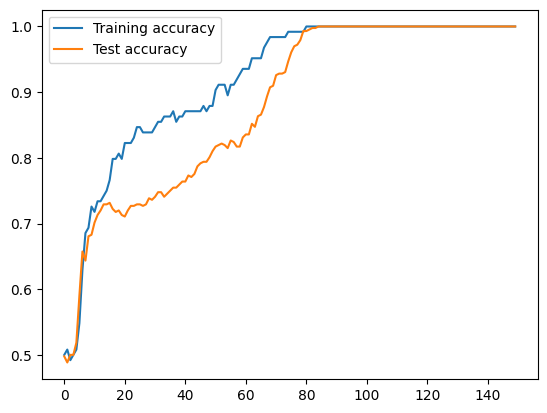

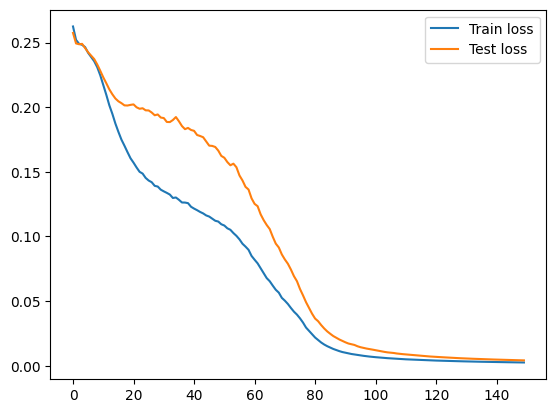

14/14 [==============================] - 0s 1ms/step - loss: 0.0041 - accuracy: 1.0000
[0.004125872626900673, 1.0]


In [141]:
model = grid_search(params, x_train, y_train, k_fold_val, x_test, y_test)
test_model(model, x_test, y_test)

# Monks 2

In [137]:
x_train, y_train, x_test, y_test = load_dataset("monks2", True)
print(x_train.shape, y_train.shape)
print(x_test.shape, y_test.shape)

Loaded ./../data/monks-2 dataset
(169, 17) (169,)
(432, 17) (432,)


In [138]:
model = grid_search(params, x_train, y_train, k_fold_val, x_test, y_test)
test_model(model, x_test, y_test)

Testing configuration 1/1:
{'batch_size': None, 'learning_rate': 0.1, 'max_epochs': 500, 'momentum': 0.9, 'initialization': {'type': 'uniform', 'min': -0.5, 'max': 0.5}, 'early_stopping': {'monitor': 'val_loss', 'patience': 20, 'delta': 0.001}, 'task': 'classification', 'trials_train': 5, 'trials_test': 10, 'regularization': {'method': None}, 'activations_1': 'relu', 'units_1': 5}
Executing fold 1/5


100%|█████████████████████████████████████████████| 5/5 [00:17<00:00,  3.43s/it]


Fold 1/5 median val_loss: 0.22347776591777802
Fold 1/5 median train_loss: 0.2325308471918106
Fold 1/5 median val_accuracy: 0.6764705777168274
Fold 1/5 median train_accuracy: 0.6074073910713196
Executing fold 2/5


100%|█████████████████████████████████████████████| 5/5 [00:18<00:00,  3.74s/it]


Fold 2/5 median val_loss: 0.002169596264138818
Fold 2/5 median train_loss: 0.0015933680115267634
Fold 2/5 median val_accuracy: 1.0
Fold 2/5 median train_accuracy: 1.0
Executing fold 3/5


100%|█████████████████████████████████████████████| 5/5 [00:24<00:00,  4.93s/it]


Fold 3/5 median val_loss: 0.0023157440591603518
Fold 3/5 median train_loss: 0.0017830441938713193
Fold 3/5 median val_accuracy: 1.0
Fold 3/5 median train_accuracy: 1.0
Executing fold 4/5


100%|█████████████████████████████████████████████| 5/5 [00:18<00:00,  3.67s/it]


Fold 4/5 median val_loss: 0.07802432775497437
Fold 4/5 median train_loss: 0.08665571361780167
Fold 4/5 median val_accuracy: 0.9117646813392639
Fold 4/5 median train_accuracy: 0.8962963223457336
Executing fold 5/5


100%|█████████████████████████████████████████████| 5/5 [00:12<00:00,  2.55s/it]

Fold 5/5 median val_loss: 0.23593862354755402
Fold 5/5 median train_loss: 0.16424164175987244
Fold 5/5 median val_accuracy: 0.6060606241226196
Fold 5/5 median train_accuracy: 0.7573529481887817
Mean val_loss: 0.10838521150872112
Mean train_loss: 0.09736092295497656
Mean val_accuracy: 0.8388591766357422
Mean train_accuracy: 0.8388591766357422






Best configuration (loss 0.10838521150872112):
{'batch_size': None, 'learning_rate': 0.1, 'max_epochs': 500, 'momentum': 0.9, 'initialization': {'type': 'uniform', 'min': -0.5, 'max': 0.5}, 'early_stopping': {'monitor': 'val_loss', 'patience': 20, 'delta': 0.001}, 'task': 'classification', 'trials_train': 5, 'trials_test': 10, 'regularization': {'method': None}, 'activations_1': 'relu', 'units_1': 5}


ValueError: The truth value of an array with more than one element is ambiguous. Use a.any() or a.all()

# Monks 3

In [15]:
x_train, y_train, x_test, y_test = load_dataset("monks3", True)
print(x_train.shape, y_train.shape)
print(x_test.shape, y_test.shape)

Loaded ./../data/monks-3 dataset
(122, 17) (122,)
(432, 17) (432,)


  0%|                                                     | 0/1 [00:00<?, ?it/s]

{'batch_size': None, 'learning_rate': 0.1, 'max_epochs': 500, 'momentum': 0.9, 'regularizer': None, 'initialization': {'type': 'uniform', 'min': -0.5, 'max': 0.5}, 'early_stopping': {'monitor': 'val_loss', 'patience': 20, 'delta': 0.001}, 'task': 'classification', 'activations_1': 'relu', 'units_1': 5}


100%|█████████████████████████████████████████████| 1/1 [00:11<00:00, 11.76s/it]

0.23260994602081386



{'batch_size': None, 'learning_rate': 0.1, 'max_epochs': 500, 'momentum': 0.9, 'regularizer': None, 'initialization': {'type': 'uniform', 'min': -0.5, 'max': 0.5}, 'early_stopping': {'monitor': 'val_loss', 'patience': 20, 'delta': 0.001}, 'task': 'classification', 'activations_1': 'relu', 'units_1': 5}
0.23260994602081386


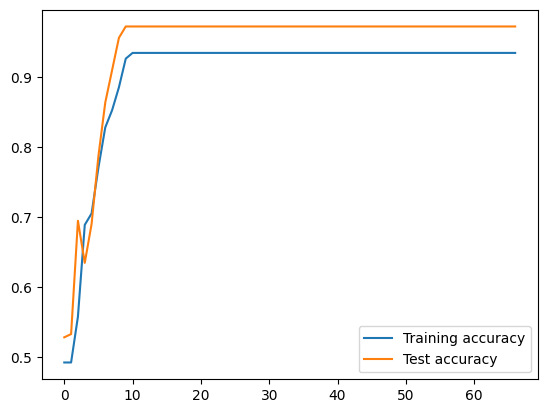

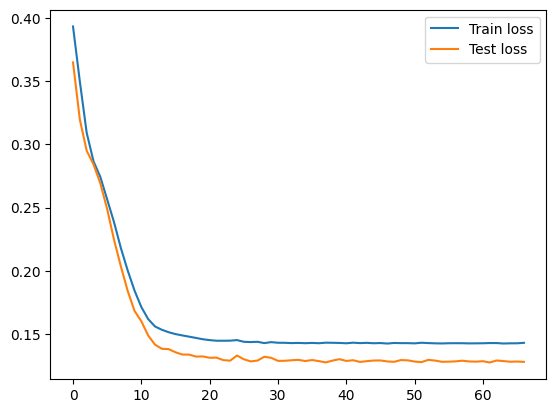

14/14 [==============================] - 0s 2ms/step - loss: 0.1280 - accuracy: 0.9722
[0.12798188626766205, 0.9722222089767456]


In [20]:
model = grid_search(params, x_train, y_train, k_fold_val, x_test, y_test)
test_model(model, x_test, y_test)

# ML Cup

In [201]:
x_train, y_train, x_test, _ = load_dataset("cup", True)
print(x_train.shape, y_train.shape)
print(x_test.shape)

(1492, 9) (1492, 2)
(529, 9)


In [221]:
params = {
    "task": "regression",
    "trials_train": 5,
    "trials_test": 10,
    "initialization": {
        "type": "uniform",
        "min": -0.5,
        "max": 0.5
    },
    "early_stopping": {
        "monitor": "val_loss",
        "patience": 30,
        "delta": 0.000
    },
    "max_epochs": [500],
    "learning_rate": [0.1],
    "batch_size": [None],
    "momentum": [0.9],
    "regularization": [
        {
            "type": "l1",
            "value": [0.001, 0.01, 0.1, 1]
        }
    ],
    "layers": [
        {
            "activations": ["relu"],
            "units": [5],
        },
    ]
}


k_fold_val = {
    "type": "k-fold",
    "n_folds": 5
}

hold_out_val = {
    "type": "hold-out",
    "val_split": 0.15
}

In [ ]:
model = grid_search(params, x_train, y_train, k_fold_val)
model.summary()
# test_model(model, x_test, y_test)

Testing configuration 1/4:
{'batch_size': None, 'learning_rate': 0.1, 'max_epochs': 500, 'momentum': 0.9, 'initialization': {'type': 'uniform', 'min': -0.5, 'max': 0.5}, 'early_stopping': {'monitor': 'val_loss', 'patience': 30, 'delta': 0.0}, 'task': 'regression', 'trials_train': 5, 'trials_test': 10, 'regularization': {'method': 'l1', 'value': 0.001}, 'activations_1': 'relu', 'units_1': 5}
Executing fold 1/5


100%|█████████████████████████████████████████████| 5/5 [00:22<00:00,  4.54s/it]


Fold 1/5 median val_loss: 0.13240954279899597
Fold 1/5 median train_loss: 0.14815422892570496
Fold 1/5 median val_mse: 0.11672226339578629
Fold 1/5 median train_mse: 0.13304764032363892
Executing fold 2/5


100%|█████████████████████████████████████████████| 5/5 [00:30<00:00,  6.03s/it]


Fold 2/5 median val_loss: 0.12379857152700424
Fold 2/5 median train_loss: 0.13024917244911194
Fold 2/5 median val_mse: 0.11111077666282654
Fold 2/5 median train_mse: 0.11727619916200638
Executing fold 3/5


100%|█████████████████████████████████████████████| 5/5 [00:25<00:00,  5.14s/it]


Fold 3/5 median val_loss: 0.1531974971294403
Fold 3/5 median train_loss: 0.14466649293899536
Fold 3/5 median val_mse: 0.13794080913066864
Fold 3/5 median train_mse: 0.129253551363945
Executing fold 4/5


 80%|████████████████████████████████████         | 4/5 [00:23<00:06,  6.05s/it]

47/47 [==============================] - 0s 1ms/step


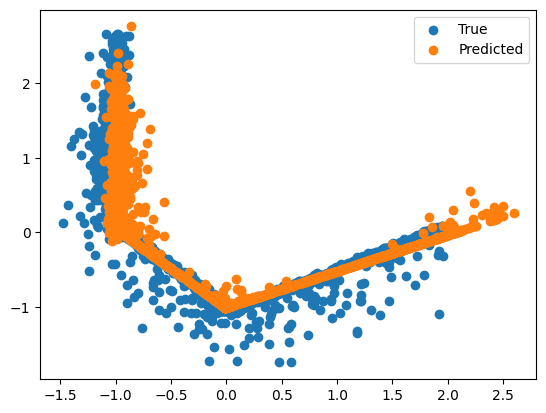

In [214]:
plt.scatter(y_train[:, 0], y_train[:, 1], label="True")
pred = model.predict(x_train)
plt.scatter(pred[:, 0], pred[:, 1], label = "Predicted")
plt.legend()
plt.show()